In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./A_target_count_encoding/A00_setup.py").load_module()
os.getcwd()

'/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code'

# XGBoost, XGBoost, Target Encoding DGI Feeatures: DGI hierarchy (start point)
No blending of hierarchy, just target encode all of the DGI hierarchy features (separately).  Vary DGI group features, using NAICS + DGI features above a certain level.

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot, sg_blender
# Hierarchical encoder on one feature is just regular target encoding
from sba_gnn.sba_gnn.sg_blender import HierarchicalEncoder 

In [6]:
sg_plot.plot_defaults()

## Import Processed Datasets

In [7]:
sba_loans = pd.read_parquet(Path(setup.parent_path).joinpath('01_DATA_transformed.parquet')) 

In [8]:
best_params_df = pd.read_csv(Path(setup.parent_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

In [9]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

##### Append DGI info

In [10]:
##### DGI info
embed_df = pd.read_parquet(Path(setup.parent_path).joinpath('63_DATA_embeddings_tsne_naics.parquet'))

In [11]:
# Group counts
naics_grp_counts = pd.read_csv(Path(setup.parent_path).joinpath('02_REPORT_naics_grp_stats_all.csv')) \
    [['level_0', 'count_grp']] \
    .drop_duplicates() \
    .set_axis(['naics_type', 'k'], axis=1)

In [12]:
naics_grp_k = naics_grp_counts['k'].drop_duplicates().sort_values().to_list()
naics_grp_k

[20.0, 106.0, 354.0, 834.0]

In [13]:
cluster_cols = sorted([c for c in embed_df if c.startswith('cluster_')],
                      reverse=True)
cluster_cols

['cluster_834',
 'cluster_354',
 'cluster_106',
 'cluster_020',
 'cluster_010',
 'cluster_003']

In [14]:
cluster_cols_sel = sorted([c for c in cluster_cols if int(c.split('_')[1]) in naics_grp_k],
                         reverse=True)
cluster_cols_sel

['cluster_834', 'cluster_354', 'cluster_106', 'cluster_020']

In [15]:
sba_loans = sba_loans.drop(columns = cluster_cols_sel, errors='ignore') \
    .merge(embed_df[['NAICS_orig'] + cluster_cols_sel] \
               .rename(columns={'NAICS_orig':'NAICS'}),
           on='NAICS', how='left')

##### Comparison metrics

In [16]:
# Hierarchical encoding, lambda_k = 100
metrics_base = pd.read_csv(Path(setup.parent_path).joinpath('X66_REPORT_metrics.csv'))

In [17]:
# Regular, non-hierarchical target encoding, for a horizontal reference line
metrics_tenc = pd.read_csv(Path(setup.parent_path).joinpath('14_REPORT_metrics.csv'))

In [18]:
# Target+Count
metrics_tc = pd.read_csv(Path(setup.temp_path).joinpath('A07_REPORT_metrics.csv'))

In [19]:
# Target-Thresh
metrics_tt = pd.read_csv(Path(setup.temp_path).joinpath('A14_REPORT_metrics.csv'))

## Function to get metrics

In [20]:
def get_metrics(data, lambda_k = setup.selected_lambda_k, 
                enc_features = ['NAICS', 'NAICS_5', 'NAICS_4', 'NAICS_3', 'NAICS_sector']):
    
    # Alternative encoding
    train_df = data[data['dset'] == 'train']
    enc_dict = {f:HierarchicalEncoder(lambda_k = lambda_k) for f in enc_features}
    [enc_dict[f].fit(train_df[[f]], train_df['target']) for f in enc_features]
    enc_val = pd.concat([enc_dict[f].transform(data[[f]]) for f in enc_features],
                    axis=1, keys=enc_features)
    
    # Append to data
    data = pd.concat([data.drop(columns=enc_val.columns, errors='ignore'), enc_val], 
                      axis=1)
    train_df = data[data['dset'] == 'train']
    test_df = data[data['dset'] == 'test']
    val_df = data[data['dset'] == 'val']
    
    predictor_features = setup.predictor_features + list(enc_val.columns)

    # Model fit
    xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)
    xgb_model = xgb_model.set_params(**xgb_params)
    xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])
    
    # Predict
    pred_df = pd.concat([data[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(data[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')
    
    # Decision threshold
    pred_train_df = pred_df[pred_df['dset'] == 'train']
    thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])
    thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
    best_thresh = thresh_head['thresh'].iloc[0]
    pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)
    
    # Metrics
    metrics_dset_df = pred_df.groupby('dset') \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
        .groupby(['dset', 'dset_naics_holdout']) \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
    
    return pred_df, metrics_df

## Loop to get predictions, metrics

In [21]:
# Encode NAICS + DGI from different levels
naics_sets = [['NAICS', 'cluster_834', 'cluster_354', 'cluster_106', 'cluster_020'],
              ['NAICS', 'cluster_354', 'cluster_106', 'cluster_020'],
              ['NAICS', 'cluster_106', 'cluster_020'],
              ['NAICS', 'cluster_020']]

In [22]:
%%capture
pred_df = pd.DataFrame()
metrics_df = pd.DataFrame()
for this_set in naics_sets:
    this_pred, this_met = get_metrics(sba_loans, enc_features=this_set)
    this_pred['naics_type'] = this_set[1]
    pred_df = pd.concat([pred_df, this_pred])
    this_met['naics_type'] = this_set[1]
    metrics_df = pd.concat([metrics_df, this_met])

In [23]:
metrics_df[metrics_df['dset_naics_holdout'] == 1]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,naics_type
1,test,0.630649,0.414561,0.291136,0.719651,0.331534,0.719168,1.0,cluster_834
1,test,0.633647,0.413871,0.291758,0.711784,0.327572,0.717215,1.0,cluster_354
1,test,0.625453,0.412112,0.288280,0.722443,0.317864,0.712320,1.0,cluster_106
1,test,0.633232,0.412644,0.291007,0.708992,0.319566,0.712703,1.0,cluster_020


In [24]:
metrics_df[metrics_df['dset_naics_holdout'] == 0]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,naics_type
0,test,0.660361,0.450591,0.337639,0.677106,0.384407,0.729448,0.0,cluster_834
0,test,0.660596,0.450439,0.337689,0.676221,0.384379,0.729364,0.0,cluster_354
0,test,0.659986,0.450375,0.337358,0.677262,0.383754,0.729419,0.0,cluster_106
0,test,0.659826,0.450278,0.337236,0.677314,0.384502,0.729275,0.0,cluster_020


In [25]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('A33_DATA_combined_predictions.parquet'))
metrics_df.to_csv(Path(setup.temp_path).joinpath('A33_REPORT_metrics.csv'), index=True)

## Comparison Plot

In [26]:
col_map = dict(zip(cluster_cols_sel, reversed(naics_grp_k)))
label_k = sorted([int(c) for c in col_map.values()])

In [27]:
metrics_sum = metrics_df[~metrics_df['dset_naics_holdout'].isna()].copy()
metrics_sum['k'] = metrics_sum['naics_type'].apply(lambda x: col_map[x]).astype('int')

In [28]:
metrics_base_sum = metrics_base[~metrics_base['dset_naics_holdout'].isna()].copy()
metrics_base_sum['k'] = metrics_base_sum['start_naics'].apply(lambda x: col_map[x]).astype('int')

In [29]:
metrics_tc_sum = metrics_tc[~metrics_tc['dset_naics_holdout'].isna()].copy()
metrics_tc_sum['k'] = metrics_tc_sum['naics_type'].apply(lambda x: col_map[x]).astype('int')

In [30]:
metrics_tt_sum = metrics_tt[~metrics_tt['dset_naics_holdout'].isna()].copy()
metrics_tt_sum['k'] = metrics_tt['naics_type'].apply(lambda x: col_map[x]).astype('int')

In [31]:
metrics_sum_dict = {'mhier':metrics_base_sum,
                    'menc_all': metrics_sum,
                    'tc': metrics_tc_sum,
                    'tt': metrics_tt_sum}

In [32]:
# Reference lines
hline_test = metrics_tenc[(metrics_tenc['dset_naics_holdout'] == 0) &
                          (metrics_tenc['c'] == setup.selected_lambda_k)] \
    ['average_precision_score'].iloc[0]
hline_ho = metrics_tenc[(metrics_tenc['dset_naics_holdout'] == 1) &
                          (metrics_tenc['c'] == setup.selected_lambda_k)] \
    ['average_precision_score'].iloc[0]
print(f'Regular target encoding test result: {hline_test}; holdout {hline_ho}')

Regular target encoding test result: 0.382950251407698; holdout 0.346336505844941


In [33]:
def make_plot(sum_dict, holdout_val, hline_val, yfeature, ylabel,
              title = None, titlesize = 16, legendsize = 12,
              ax = None):
    m_dict = {k: v[v['dset_naics_holdout'] == holdout_val] for k, v in sum_dict.items()}
    return sg_plot.curve_compare_hline(m_dict, hline_val=hline_val,
                                       style_dict =setup.model_label_styles,
                                       color_dict = setup.model_label_colors,
                                       label_dict = setup.model_label_dict,
                                       xfeature = 'k',
                                       yfeature = yfeature,
                                       xlabel='Group Count (k)',
                                       ylabel = ylabel,
                                       titlesize = titlesize,
                                       legendsize = legendsize,
                                       title = title,
                                      ax=ax)

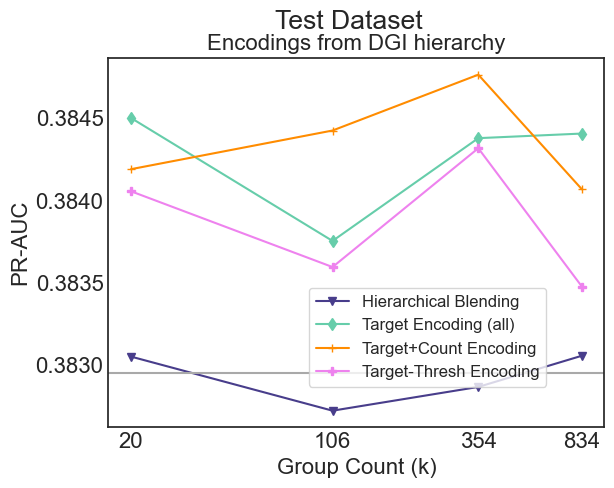

In [34]:
fig = make_plot(metrics_sum_dict, 0, hline_test,
                yfeature = 'average_precision_score',
                ylabel='PR-AUC',
                title='Encodings from DGI hierarchy')
fig.suptitle('Test Dataset')
plt.gca().legend(frameon=True, fontsize=12).set_bbox_to_anchor((0.9, 0.4))
plt.gca().set_xticks(label_k)
plt.gca().set_xticklabels(label_k)
fig.savefig(Path(setup.temp_path).joinpath('A33_PLOT_compare_base_reg.png'),
            bbox_inches='tight')

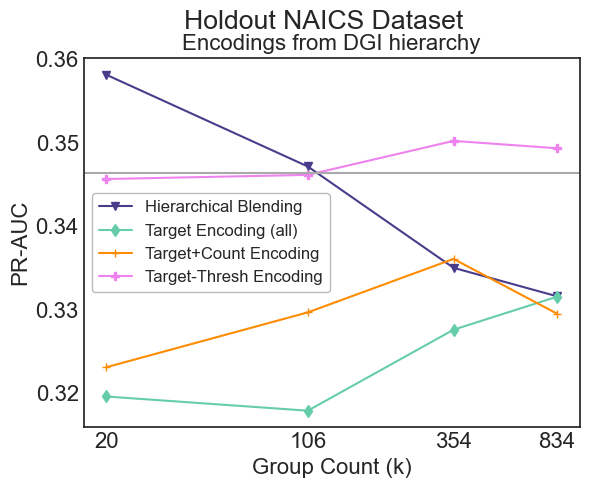

In [35]:
fig = make_plot(metrics_sum_dict, 1, hline_ho,
                yfeature = 'average_precision_score',
                ylabel='PR-AUC',
                title='Encodings from DGI hierarchy')
fig.suptitle('Holdout NAICS Dataset')
plt.gca().set_xticks(label_k)
plt.gca().set_xticklabels(label_k)
fig.savefig(Path(setup.temp_path).joinpath('A33_PLOT_compare_base_ho.png'),
            bbox_inches='tight')

##### Combined plot

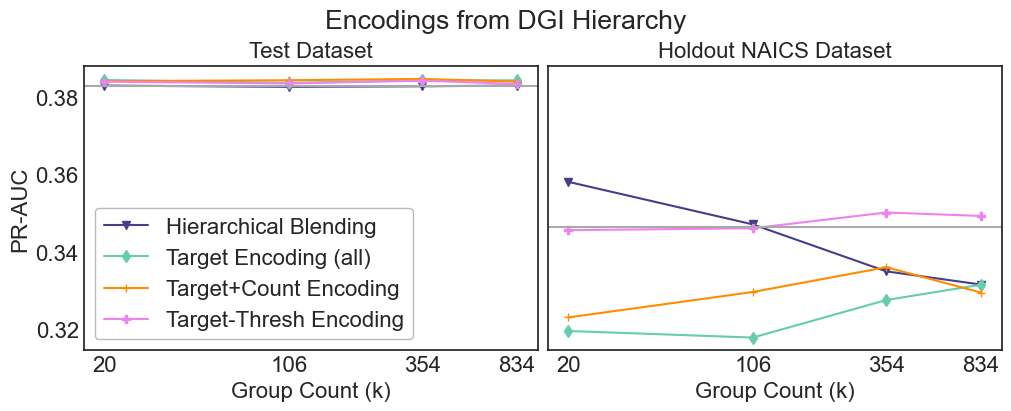

In [42]:
# Combined plot
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True,
                      figsize = (10,4), layout='constrained')
make_plot(metrics_sum_dict, 0, hline_test,
                yfeature = 'average_precision_score',
                ylabel='PR-AUC',
                title='Test Dataset',
         ax=ax[0],
         legendsize=16)
make_plot(metrics_sum_dict, 1, hline_ho,
                yfeature = 'average_precision_score',
                ylabel='PR-AUC',
                title='Holdout NAICS Dataset',
         ax=ax[1])
ax[0].set_xticks(label_k)
ax[0].set_xticklabels(label_k)
ax[1].set_xticks(label_k)
ax[1].set_xticklabels(label_k)
ax[1].legend().set_visible(False)
fig.suptitle('Encodings from DGI Hierarchy')
fig.savefig(Path(setup.temp_path).joinpath('A33_PLOT_compare_base_combined.png'),
            bbox_inches='tight')

## Train Comparison
Same plots, relative to train PR-AUC

In [37]:
# Reference line for standard target encoding
hline_train = metrics_tenc[(metrics_tenc['dset'] == 'train') &
                          (metrics_tenc['c'] == setup.selected_lambda_k)] \
    ['average_precision_score'].iloc[0]
delta_target_test = hline_test - hline_train
delta_target_ho =  hline_ho -  hline_train      
print(f'Regular target encoding train deltas: {delta_target_test}; holdout {delta_target_ho}')

Regular target encoding train deltas: -0.00950607699637157; holdout -0.046119822559128554


In [38]:
def get_delta(m_sum, m):
    m_delta = m_sum \
        .rename(columns={'start_naics':'naics_type'}, errors='ignore') \
        .merge(m[m['dset'] == 'train'] \
                   .rename(columns={'start_naics':'naics_type'}, errors='ignore') \
                    [['naics_type', 'average_precision_score']] \
               .rename(columns={'average_precision_score':'base_prauc'}),
           on='naics_type')
    m_delta['delta'] = m_delta['average_precision_score'] - m_delta['base_prauc'] 
    return m_delta

In [39]:
metrics_base_delta = get_delta(metrics_base_sum, metrics_base)
metrics_sum_delta = get_delta(metrics_sum, metrics_df)
metrics_tt_delta = get_delta(metrics_tt_sum, metrics_tt)
metrics_tc_delta = get_delta(metrics_tc_sum, metrics_tc)

In [40]:
metrics_delta_dict = {'mhier':metrics_base_delta,
                    'menc_all': metrics_sum_delta,
                    'tc': metrics_tt_delta,
                    'tt': metrics_tc_delta}

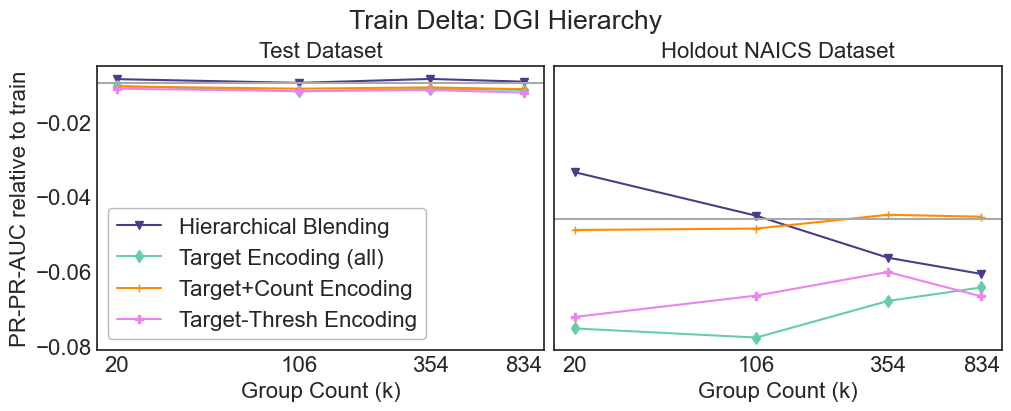

In [48]:
# Combined plot
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True,
                      figsize = (10,4), layout='constrained')
make_plot(metrics_delta_dict, 0, delta_target_test,
                yfeature = 'delta',
                ylabel='PR-PR-AUC relative to train',
                title='Test Dataset',
         ax=ax[0],
         legendsize=16)
make_plot(metrics_delta_dict, 1, delta_target_ho,
                yfeature = 'delta',
                ylabel='PR-AUC',
                title='Holdout NAICS Dataset',
         ax=ax[1])
ax[0].set_xticks(label_k)
ax[0].set_xticklabels(label_k)
ax[1].set_xticks(label_k)
ax[1].set_xticklabels(label_k)
ax[1].legend().set_visible(False)
fig.suptitle('Train Delta: DGI Hierarchy')
fig.savefig(Path(setup.temp_path).joinpath('A33_PLOT_compare_train_deltas.png'),
            bbox_inches='tight')